# Modeling task 2

Данный ноутбук направлен на решение второй задачи: группировки каверов и исходного трека.

Решать данную задачу планируем в 2 этапа: 
1. Находить k ближайших треков по веторизованному тексту песни.
2. При помощи ML модели определять какие из предложенных треков можно сгруппировать.

Как всегда импортируем библиотеки и прописываем пути к файлам

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from statistics import mean

from tqdm import tqdm
import copy

import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier

import faiss
from faiss import write_index

import pickle

from typing import Dict, List, Tuple, Callable

In [2]:
PATH_TRAIN_FAISS = 'data/preprocessing/train_faiss.csv'
PATH_TEST_FAISS = 'data/preprocessing/test_faiss.csv'
PATH_VALID_FAISS = 'data/preprocessing/valid_faiss.csv'
PATH_ALL_FAISS = 'data/preprocessing/all_faiss.csv'
PATH_UNITED_DF = 'data/preprocessing/united_df.csv'

PATH_TFIDFVECTORIZER = 'models/task_2_tfidf.pkl'

PATH_TRAIN_CORPUS = 'data/preprocessing/train_corpus.npz'
PATH_TEST_CORPUS = 'data/preprocessing/test_corpus.npz'
PATH_VALID_CORPUS = 'data/preprocessing/valid_corpus.npz'

PATH_TO_SAVE_COLUMNS_TO_DROP = 'data/preprocessing/drop_columns'
PATH_TO_SAVE_ID_BASE_DICT= 'data/preprocessing/id_base_dict'
PATH_TO_SAVE_FAISS = 'models/task_2_faiss.pkl'
PATH_TO_SAVE_MODEL = 'models/task_2_model.pkl'
PATH_SAVE_ALL_FAISS = 'data/preprocessing/all_faiss.csv'
PATH_SAVE_PREDICTION = 'data/preprocessing/prdeiction.csv'

RANDOM_STATE = 54321

Загрузим датасеты для обучения

In [3]:
df_train = pd.read_csv(PATH_TRAIN_FAISS)
df_test = pd.read_csv(PATH_TEST_FAISS)
df_valid = pd.read_csv(PATH_VALID_FAISS)

Для того чтобы открыть векторизованные корпуса, полученные на препроцессинге, создадим функцию, которая прочитает разряженные матрицы.

In [4]:
def load_sparse_csr(filename: str):
    loader = np.load(filename)
    return scipy.sparse.csr_matrix((loader['data'],
                                    loader['indices'],
                                    loader['indptr']),
                                   shape=loader['shape'])

Загрузим векторизованные корпуса

In [5]:
corpus_train = load_sparse_csr(PATH_TRAIN_CORPUS)
corpus_test = load_sparse_csr(PATH_TEST_CORPUS)
corpus_valid = load_sparse_csr(PATH_VALID_CORPUS)

## Модель для нахождения k претендентов на кавер.

Для решения задачи группировки треков будем использовать faiss данная библиотека работает немного быстрее классического варианта K-ближайших, а также имеет возможность дальнейшей оптимизации.

Чтобы оценивать качество работы данной модели, а также подбирать гиперпарамтеры воспользуемся метрикой **𝑅𝑒𝑐𝑎𝑙𝑙@𝑘** (полнота на k элементах), поскольку для данного этапа нам необходимо сделать модель, которая будет отбирать максимально подходящие треки для данного трека.

Её можно рассчитать по формуле:

$$ Recall@k =  {\sum найденных \space в \space топk \space матчей \over \sum матчей} $$

Созадим функцию для её рассчёта:

In [6]:
def score_recall_k(y_true: pd.Series, y_pred: pd.Series) -> float:
    metrick_list = []
    for i, y_p in enumerate(y_pred):
        # проверим есть ли для данного трека вообще каверы, tсли есть, то посчитаем количество вхождений
        if y_true[i] is not np.nan:
            for y_t in y_true[i].split():
                metrick_list.append(1 if y_t in y_p else 0)
    return mean(metrick_list)    

Создадим словарь с track_id тренировочного датасета, поскольку фаис будет возвращать индекс строки, а проверять нам потребуется track_id

In [7]:
id_base_dict = dict(df_train['track_id'])

Получим цели обучения (списки с track_id каверов)

In [8]:
y_train = df_train['cover_list']
y_test = df_test['cover_list']
y_valid = df_valid['cover_list']

Напишем функцию для тренировки faiss

In [9]:
def faiss_fit(corpus_train: scipy.sparse, 
              n_list: int = 1, 
              random_state: int = 54321) -> faiss.IndexIVFFlat:
    x_train = copy.deepcopy(corpus_train)
    d = x_train.shape[1] 
    nb = x_train.shape[0] 
    np.random.seed(random_state) 

    xb = x_train.toarray()

    nlist = n_list
    quantizer = faiss.IndexFlatIP(d)  
    index = faiss.IndexIVFFlat(quantizer, d, nlist)
    assert not index.is_trained
    index.train(xb)
    assert index.is_trained
    index.add(xb)
    
    return index

Создадим функцию для предсказаний

In [10]:
def faiss_predict(index: faiss.IndexIVFFlat, 
                  corpus_test: scipy.sparse, 
                  id_base_dict: Dict, 
                  k: int = 10) -> pd.Series:
    x_test = copy.deepcopy(corpus_test)
    xq_x_test = x_test.toarray()
    
    D, I = index.search(xq_x_test, k)
    predicted_list = []
    distance_list = []
    
    # перебираем все ответы и проверяем, чтобы они не были равны 1 и не равнялись
    for i, candidates in enumerate(I):
        cand_list = []
        dist_list = []
        for j, candidate in enumerate(candidates):
            if candidate != -1 and id_base_dict[candidate] != id_base_dict[i]:
                cand_list.append(id_base_dict[candidate])
                dist_list.append(D[i][j])
                
        predicted_list.append(cand_list)
        distance_list.append(dist_list)      

    return pd.Series(predicted_list), pd.Series(distance_list)

Обучим индекс.

In [11]:
f_index = faiss_fit(corpus_train, random_state=RANDOM_STATE)

Проверим качество модели на трейне

In [12]:
y_train_pred, dist_train_pred= faiss_predict(f_index, corpus_train, id_base_dict, 10)
score_recall_k(y_train, y_train_pred)

0.5991379310344828

Попробуем улучшить качество модели. Для начала поработаем с TfIdf будем экспериментировать н-граммами и максимальным количеством признаков.

### Подбор параметров TfidfVectorizer

In [13]:
nltk.download('stopwords')
stopwords = nltk_stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yaros\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Создадим функцию, которая на вход будет принимать датасет, стоп слова, и параметры для TfIdf, а возвращать датасет с информацией об изменение метрики в зависимости от этих параметров

In [14]:
def feature_selection_tf_idf(df: pd.DataFrame, 
                             id_base_dict,
                             y_train: pd.Series,
                             stopwords: nltk_stopwords.words,
                             min_ngram: int = 1,
                             max_ngram: int = 6,
                             min_features: int = 100,
                             max_features: int = 20500,
                             count_steps_features: int = 20,
                             random_state: int = 54321) -> pd.DataFrame:
    score_df = pd.DataFrame(columns = ['n_gram', 'max_features', 'metric'])
    new_df = df.copy(deep=True)
    new_df['lemm_text'] = new_df['lemm_text'].fillna('')
    # определяем размер шага для признаков
    step_features = (max_features - min_features) // 20
    step_features = step_features if (max_features - min_features) % 20 == 0 else step_features + 1
    
    for n_gram in tqdm(range(min_ngram, max_ngram)):
        for count_features in range (min_features, max_features, step_features):
            tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, n_gram), max_features = count_features)
            corpus_train = tf_idf.fit_transform(new_df['lemm_text'])
            
            f_index = faiss_fit(corpus_train, random_state = random_state)
            y_train_pred, dist_train_pred= faiss_predict(f_index, corpus_train, id_base_dict, 10)
            metric = score_recall_k(y_train, y_train_pred)
            
            score_df.loc[len(score_df.index )] = [n_gram, count_features, metric]
            
    return score_df

In [15]:
df_score = feature_selection_tf_idf(df_train, id_base_dict, y_train, stopwords)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:53<00:00, 70.68s/it]


Посмотрим на получившийся датасет

In [16]:
df_score.head()

,n_gram,max_features,metric
0,1.0,100.0,0.541872
1,1.0,1120.0,0.586207
2,1.0,2140.0,0.597906
3,1.0,3160.0,0.599138
4,1.0,4180.0,0.599138


Создадим функцию, которая будет строить график по этому датасету

In [17]:
def draw_plot(df: pd.DataFrame):
    plt.figure(figsize = (10, 6))
    plt.title('Зависимость качества модели faiss от параметра max_features и количества n-gram векторизатора TfidfVectorizer')
    for n_gram in df['n_gram'].unique():
        df_for_plot = df[df['n_gram'] == n_gram]
        plt.plot(df_for_plot['max_features'], df_for_plot['metric'], label = f'n_gram {n_gram}')
    plt.xlabel('max_features')
    plt.ylabel('Recall@10')
    plt.legend()
    plt.grid()
    plt.show()

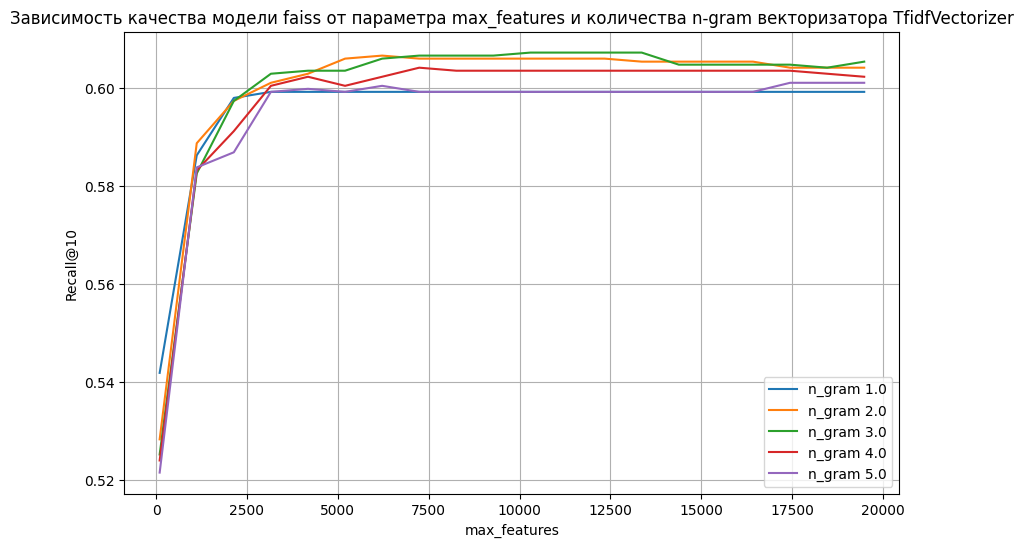

In [18]:
draw_plot(df_score)

Лучшие метрики получаются в районе max_features = 11000 - 12000 рассмотрим диапазон от 10000 до 14000 более подробно

In [19]:
df_score = feature_selection_tf_idf(df_train, 
                                    id_base_dict,
                                    y_train, 
                                    stopwords, 
                                    min_features = 10000, 
                                    max_features = 14000,
                                    count_steps_features=1000)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:54<00:00, 82.89s/it]


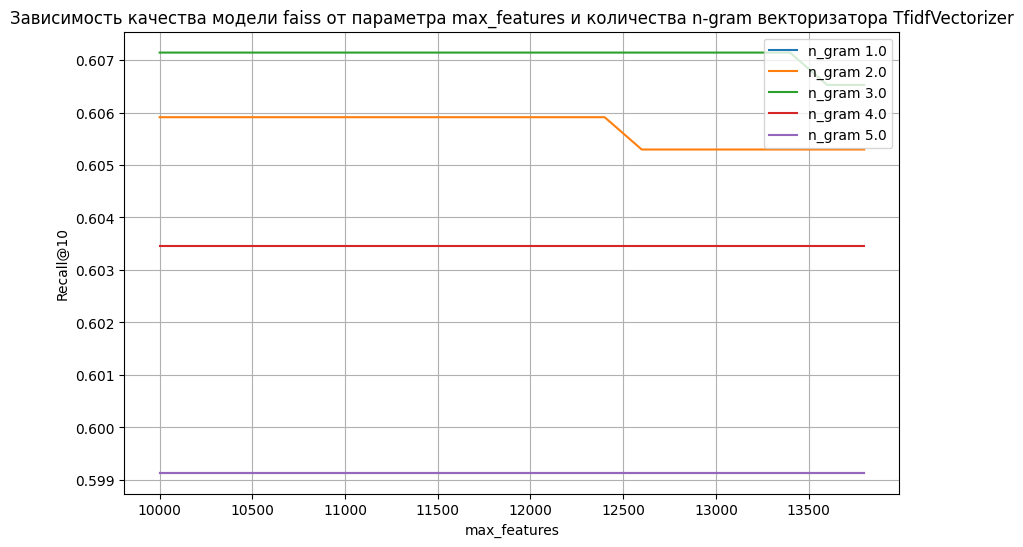

In [20]:
draw_plot(df_score)

На данном участке лидирует n_gram = (1,3), при этом качество стабильно на всём участке, так что будем использовать max_features = 10000 (это немного снизит размерность векторизованного текста)

Переучим TfIdf и сформируем новые корпуса для дальнейшего исследования.

In [21]:
tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 3), max_features = 10000)
corpus_train = tf_idf.fit_transform(df_train['lemm_text'].fillna(''))
corpus_test = tf_idf.transform(df_test['lemm_text'].fillna(''))
corpus_valid = tf_idf.transform(df_valid['lemm_text'].fillna(''))

Пересохраним обученный TfIdf

In [22]:
pickle.dump(tf_idf, open(PATH_TFIDFVECTORIZER, "wb"))

### Подбор гиперпараметров для faiss

У самого faiss есть достаточно много гиперпарамеров, но в основном они направлены на оптимизацию скорости выполнения запроса, поэтому мы будем рассматривать изменение только одного параметра, а именно возвращаемое количество соседей (k). Ожидается, что при увеличении k постепенно будет увеличиваться Recall@k, но при этом точность модели будет падать, что усложнит дальнейшее обучение модели следующего этапа. Поэтому создадим функцию, которая будет рассчитывать точность на k образцах, а f1 меру посчитаем на основании полученных данных.

In [23]:
def score_precision_k(y_true: pd.Series, y_pred: pd.Series) -> float:
    metrick_list = []
    for i, y_t in enumerate(y_true):
        for y_p in y_pred[i]:       
            if y_t is np.nan:
                metrick_list.append(0)
            else:
                metrick_list.append(1 if y_p in y_t else 0)
    return mean(metrick_list)  

Напишем функцию, которая также будет возвращать датасет с метриками.

In [24]:
def feature_selection_tf_idf(corpus_train: scipy.sparse,
                             id_base_dict: Dict,
                             y_train: pd.Series,
                             min_k: int = 2,
                             max_k: int = 10,
                             random_state: int = 54321):
    score_df = pd.DataFrame(columns = ['k', 'recall', 'precision', 'f1'])
    
    for k in range(min_k, max_k):
        f_index = faiss_fit(corpus_train, random_state = random_state)
        y_train_pred, dist_train_pred= faiss_predict(f_index, corpus_train, id_base_dict, k=k)   
        rec = score_recall_k(y_train, y_train_pred)
        prec = score_precision_k(y_train, y_train_pred)
        f1 = 2 * rec * prec / (rec + prec)

        score_df.loc[len(score_df.index )] = [k, rec, prec, f1]
                
    return score_df

In [25]:
df_score = feature_selection_tf_idf(corpus_train,
                                    id_base_dict,
                                    y_train,
                                    max_k=40)

Построим график изменения качества модели

<Figure size 1000x900 with 0 Axes>

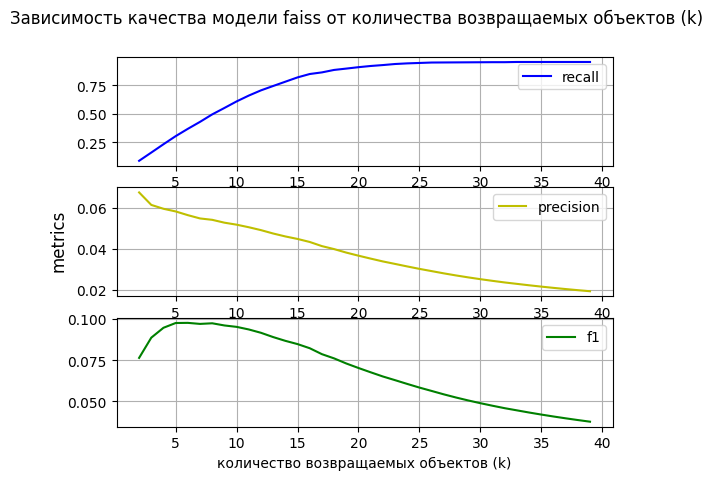

In [26]:
plt.figure(figsize = (10, 9))
fig, axs = plt.subplots(3)
fig.suptitle('Зависимость качества модели faiss от количества возвращаемых объектов (k)')
axs[0].plot(df_score['k'], df_score['recall'], label='recall', c='b')
axs[1].plot(df_score['k'], df_score['precision'], label='precision', c='y')
axs[2].plot(df_score['k'], df_score['f1'], label='f1', c='g')
plt.xlabel('количество возвращаемых объектов (k)')
fig.supylabel('metrics')
axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

Как и ожидалось, при увеличении количества образцов полнота увеличилась, а точность начала падать. Однако, если анализировать данные f1, то оптимальное значение лежит в районе 8 образцов (будем брать 8). Именно его и будем использовать.

### Обучение индекса с выбранными параметрами на новом корпусе, проверка качества на тестовой выборке, изучение полученных результатов

Заново обучим индекс и посмотрим на показания recall 

In [27]:
f_index = faiss_fit(corpus_train, random_state=RANDOM_STATE)
y_train_pred, dist_train_pred= faiss_predict(f_index, corpus_train, id_base_dict, 8)
score_recall_k(y_train, y_train_pred)

0.4938423645320197

Проверим качество на тестовой выборке

In [28]:
y_test_pred, dist_test_pred = faiss_predict(f_index, corpus_test, id_base_dict, 8)
score_recall_k(y_test, y_test_pred)

0.5473684210526316

На тестовой выборке получили примерно сопоставимое качество модели. 

Посмотрим как выглядят первы 5 строк нашего прогноза и какие значения расстояния выдаёт модель (изучать будет тренировочные данные).

In [29]:
y_train_pred[:5]

0    [b6840c6d29fadc71fa2d129dadbd066a, 70d0cf7542f...
1    [b6840c6d29fadc71fa2d129dadbd066a, c755842b935...
2    [b6840c6d29fadc71fa2d129dadbd066a, e64648eeae5...
3    [e3799880eaec350f4d3923aa93b39994, b6840c6d29f...
4    [b6840c6d29fadc71fa2d129dadbd066a, 7834aad0164...
dtype: object

In [30]:
dist_train_pred[:5]

0    [1.0, 1.5675077, 1.5926483, 1.5980024, 1.65137...
1    [1.0, 1.4988911, 1.5896583, 1.6198676, 1.67571...
2    [1.0, 1.5553735, 1.5605822, 1.6760662, 1.72098...
3    [0.5552938, 1.0, 1.5610824, 1.6554074, 1.66422...
4    [0.99999994, 1.4240391, 1.6216571, 1.6760949, ...
dtype: object

Проверим есть ли данные с разным растоянием равным 0 и разным original_track_id. И посчитаем такие пары.

In [31]:
count = 0
list_bad_track = []
for i in range(dist_train_pred.shape[0]):
    for j in range(len(dist_train_pred[i])):
        if dist_train_pred[i][j]==0:
            original_track_id_1 = df_train.loc[i, 'original_track_id']
            original_track_id_2 = (df_train
                                   .loc[df_train['track_id']==y_train_pred[i][j], 'original_track_id']
                                   .reset_index(drop=True)[0])
            if original_track_id_1 != original_track_id_2:
                count += 1
                list_bad_track.append((df_train.loc[i, 'track_id'],
                                       (df_train
                                       .loc[df_train['track_id']==y_train_pred[i][j], 'track_id']
                                       .reset_index(drop=True)[0])))
print(f'Количество пар треков с 0 расстоянием и разным original_track_id {count} ({count / y_train_pred.shape[0] * 100}%)')

Количество пар треков с 0 расстоянием и разным original_track_id 32 (1.5080113100848256%)


У нас 32 таких пар. Посмотрим на некоторые из них.

In [32]:
df_train[df_train['track_id']==list_bad_track[0][0]]

,track_id,language,duration,original_track_id,track_remake_type,missing_text,missing_title,lemm_text,lemm_title,missing_isrc,...,genre_RUSPOP,genre_JAZZ,uncnown_genre,genre_other,genre_group_ROCK,genre_group_RAP,genre_group_POP,genre_group_FOLK,genre_group_RUS,cover_list
74,995665640dc319973d3173a74a03860c,EN,179660.0,995665640dc319973d3173a74a03860c,ORIGINAL,0,0,yeah yeah remember the time baby yeah i ain t ...,the way i are,0,...,0,0,0,1,0,1,0,0,0,NaN


In [33]:
df_train[df_train['track_id']==list_bad_track[0][1]]

,track_id,language,duration,original_track_id,track_remake_type,missing_text,missing_title,lemm_text,lemm_title,missing_isrc,...,genre_RUSPOP,genre_JAZZ,uncnown_genre,genre_other,genre_group_ROCK,genre_group_RAP,genre_group_POP,genre_group_FOLK,genre_group_RUS,cover_list
995,f5b1b6321334fd64cd81d04b024e52a0,EN,199560.0,f5b1b6321334fd64cd81d04b024e52a0,ORIGINAL,0,0,yeah yeah remember the time baby yeah i ain t ...,the way i are,0,...,0,0,0,0,0,1,1,0,0,NaN


Посмотрим на вторую пару.

In [34]:
df_train[df_train['track_id']==list_bad_track[1][0]]

,track_id,language,duration,original_track_id,track_remake_type,missing_text,missing_title,lemm_text,lemm_title,missing_isrc,...,genre_RUSPOP,genre_JAZZ,uncnown_genre,genre_other,genre_group_ROCK,genre_group_RAP,genre_group_POP,genre_group_FOLK,genre_group_RUS,cover_list
77,b9213d37c37deffe8b8af0dac5d0c3c4,EN,178600.0,b9213d37c37deffe8b8af0dac5d0c3c4,ORIGINAL,0,0,heart go astray leaving hurt when they go i we...,everlasting love,0,...,0,0,0,1,0,0,0,0,0,a106cea5c02ed8a70b421831cc4e7192 0021519c8533f...


In [35]:
df_train[df_train['track_id']==list_bad_track[1][1]]

,track_id,language,duration,original_track_id,track_remake_type,missing_text,missing_title,lemm_text,lemm_title,missing_isrc,...,genre_RUSPOP,genre_JAZZ,uncnown_genre,genre_other,genre_group_ROCK,genre_group_RAP,genre_group_POP,genre_group_FOLK,genre_group_RUS,cover_list
613,522fd9c3fe5138702f643e79b49984a7,EN,178840.0,522fd9c3fe5138702f643e79b49984a7,ORIGINAL,0,0,heart go astray leaving hurt when they go i we...,everlasting love,0,...,0,0,0,1,0,0,0,0,0,NaN


Действительно, судя по всему эти песни являются каверами у них совпадаютс названия и текст, хотя они и имеют разный original_track_id.

Сохраним обученный индекс.

In [36]:
write_index(f_index, PATH_TO_SAVE_FAISS)

### Выводы

В данном разделе была разработана и обучена модель для нахождения k ближайших треков, в качестве такой модели был выбран faiss. В ходе создания модели была проделана следующая работа:
1. Выбраны метрики качества и написаны функции для их определения;
2. Подобраны оптимальные параметры для TfIdf текстов песен (n_gram = (1, 3), max_features = 10000);
3. Подобрано лучшее количество возвращаемых k ближайших (выбор осуществлялся на основании f1 меры, поскольку увеличение количества ближайших соседей увеличивает полноту, но просаживает точность). В нашей задаче будем возвращать 8 ближайших.
4. В первом приближении исследованы результаты модели, было обнаружено, что в датасете отобранном для тренировочных данных 32 пары треков с 0 расстоянием и разным original_track_id (примерно 1.5%), вероятнее всего это является ошибкой разметки данных.

## Модель принимающая решения является ли пара треков каверами

После подбора наиболее подходящих треков создадим новый датасет и поверх него обучим модель, которая будет решать является ли эта пара треков каверами / оригиналами. Для начала создадим датасет на основании предыдущего этапа моделирования. Рассмотрим следующие варианты создания датасета:

1. Добавления столбцов для обучения для каждого образца и добавления растояния между образцами;
2. Проверка на равнество для категориальных признаков, а для  количественных как в первом варианте;
3. Отношение для количественных признаков, а остальное как в первом варианте;
4. Объединение 2 и 3 варианта;
5. Объединение первых 3 вариантов (т.е. будем оставлять как первоначальные столбцы, так и сгенерированные).

В качестве **метрики** выбираем **f1** меру. **Важно** метрика будет считаться только на даных поступающих из предыдущей модели (faiss), соответственно для каждого трека будет рассмотрено только 8 претендентов на кавер. Поэтому для треков с большим количеством каверов данная метрика будет не совсем корректна.

В качестве модели будем использовать CatBoostClassifier, поскольку у нас очень много категориальных признаков и кэтбуст с ними сможет корректно работать.При этом в зависимости от модели количество категориальных столбцов может меняться.

Выделим нужные категориальные и числовые столбцы. У нас много категориальных признаков, поэтому проще будет выделить числовые признаки, признаки не несущие информацию или целевые столбцы, а потом из всего списка столбцов убрать их, оставив только категориальные признаки.

In [37]:
num_features = ['duration', 'num_year']
drop_features = ['track_id', 'original_track_id', 'track_remake_type', 'cover_list', 'lemm_text']
cat_features = list(df_train.columns)
for col in num_features + drop_features:
    cat_features.remove(col)

### Проверка модели с сохранением всех признаков для обоих образцов и добавлением расстояния между ними (модель 1)

Напишем функцию для переименования столбцов, так как нам потребуется разделять признаки для одного и для второго образца

In [38]:
def rename_columns(df: pd.DataFrame, ind: int) -> pd.DataFrame:
    df = df.copy(deep = True)
    ind = '_' + str(ind)
    columns_dict = dict()
    for column in df.columns:
        columns_dict[column] = column + ind
        
    df = df.rename(columns = columns_dict)
    return df

Создадим функцию для получения значения target, которое будет показывать входит ли трек с id_1 в состав каверов для трека с id_2 или наоборот.

In [39]:
def get_target(df: pd.DataFrame, id_1: str, id_2: str) -> int:
    target_value = ((~df.loc[df['track_id']==id_1, 'cover_list'].isna().any() and
                   id_2 in df.loc[df['track_id']==id_1, 'cover_list'].values[0]) or 
                   (~df.loc[df['track_id']==id_2, 'cover_list'].isna().any() and
                   id_1 in df.loc[df['track_id']==id_2, 'cover_list'].values[0]))
    return int(target_value)

Напишем  функцию для создания строки датасета по 2 заданным track_id

In [40]:
def get_row_to_df_v1(df: pd.DataFrame, 
                     id_1: str, 
                     id_2: str, 
                     dist: float, 
                     cat_features: List[str] = [], 
                     num_features: List[str] = [], 
                     is_train: bool = True) -> pd.DataFrame:
    all_features = num_features + cat_features
    # получаем нудные столбцы
    df_1 = df.loc[df['track_id'] == id_1, all_features].reset_index(drop=True)
    df_2 = df.loc[df['track_id'] == id_2, all_features].reset_index(drop=True)
    # переименовываем столбцы
    df_1 = rename_columns(df_1, 1)
    df_2 = rename_columns(df_2, 2)
    # объединяем
    new_df = pd.concat([df_1, df_2], axis=1)
    # добавляем расстояние
    new_df['dist'] = dist
    if is_train:
        new_df['target'] = get_target(df, id_1, id_2)
    return new_df

Создадим функцию для генерации всего датсета, при этом сделаем так, что бы она на вход принимала функцию генерации признаков, это позволит в дальнейшем переиспользовать её.

In [41]:
def get_df(df: pd.DataFrame, 
           series_pred: pd.Series, 
           series_dist: pd.Series, 
           function: Callable, 
           cat_features: List[str] = [], 
           num_features: List[str] = [],
           is_train: bool = True,
           df_for_question: pd.DataFrame = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    new_df = pd.DataFrame() # датасет для прогноза
    
    if df_for_question is not None:
        # оставляем только те track_id которых нет в основном датасете
        df_for_question = df_for_question[~df_for_question['track_id'].isin(df['track_id']).values] 
        df_for_question = pd.concat([df, df_for_question], axis=0) # формируем датасет для запроса
    else:
        df_for_question = df
    
    df_track = pd.DataFrame(columns = ['track_id_1', 'track_id_2']) # датасет для пар track_id
    for i in tqdm(range(series_pred.shape[0])):
        list_pred = series_pred[i]
        list_dist = series_dist[i]
        for j in range(len(list_pred)):
            df_match = function(df_for_question, 
                                df.loc[i, 'track_id'], 
                                list_pred[j],
                                list_dist[j],
                                cat_features,
                                num_features,
                                is_train)
            new_df = pd.concat([new_df, df_match])
            df_track.loc[ len(df_track.index )] = [df.loc[i, 'track_id'], list_pred[j]]
    return new_df.reset_index(drop=True), df_track.reset_index(drop=True)

Сгенерируем датасет

In [42]:
df_cat_train, df_track_train = get_df(df_train, y_train_pred, dist_train_pred, get_row_to_df_v1, cat_features, num_features)

100%|██████████████████████████████████████████████████████████████████████████████| 2122/2122 [01:32<00:00, 22.99it/s]


In [43]:
df_cat_train.head()

,duration_1,num_year_1,language_1,missing_text_1,missing_title_1,lemm_title_1,missing_isrc_1,cat_year_isrc_1,country_of_track_1,reg_code_1,...,genre_JAZZ_2,uncnown_genre_2,genre_other_2,genre_group_ROCK_2,genre_group_RAP_2,genre_group_POP_2,genre_group_FOLK_2,genre_group_RUS_2,dist,target
0,170000.0,2021,RU,0,0,you and me,0,2021,RU,A1D,...,0,0,0,0,0,0,0,0,1.000000,0
1,170000.0,2021,RU,0,0,you and me,0,2021,RU,A1D,...,0,0,1,0,1,0,0,1,1.567508,0
2,170000.0,2021,RU,0,0,you and me,0,2021,RU,A1D,...,0,0,1,0,0,0,0,0,1.592648,0
3,170000.0,2021,RU,0,0,you and me,0,2021,RU,A1D,...,0,0,1,0,1,0,0,1,1.598002,0
4,170000.0,2021,RU,0,0,you and me,0,2021,RU,A1D,...,0,0,0,0,0,1,0,1,1.651370,0


Поскольку названия столбцов в датасете менялись, то нужно выбрать новые списки категориальных и числовых признаков

In [44]:
def get_features_list(df: pd.DataFrame,
                      cat_features: List[str] = [], 
                      num_features: List[str] = []) -> Tuple[List, List]:
    columns = df.columns
    new_cat_features = []
    new_num_features = []
    for column in columns:
        if column[:-2] in cat_features:
            new_cat_features.append(column)
        if column[:-2] in num_features:
            new_num_features.append(column)
    return new_cat_features, new_num_features

In [45]:
new_cat_features, new_num_features = get_features_list(df_cat_train, cat_features, num_features)

Посмотрим как распределён целевой признак.

In [46]:
df_cat_train['target'].mean()

0.05399219065571563

Выделим признаки и цели обучения

In [47]:
X_train = df_cat_train.drop('target', axis=1)
y_train = df_cat_train['target']

Как видим у нас всего около 5% матчей, поэтому при обучении необходимо указать модели на дисбаланс классов. Как отмечалось ранее для обучения будем использовать CatBoostClassifier. Поскольку у нас задача свелась к задачи классификации, то в качестве метрики будем использовать f1 меру.

In [48]:
cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=new_cat_features,
                               verbose=False)

Определять качество модели будем на кроссвалидации, поскольку у нас крайне мало целевых значений, то для разделения на фолды будем использовать StratifiedKFold

In [49]:
skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

In [50]:
%%time
cvs = cross_val_score(cat_model, X_train, y_train, cv=folds, scoring='f1')
print(f'Метрика f1 на кроссвалидации {cvs}')
print(f'Среднее значение f1 на всём датасете {mean(cvs)}')

Метрика f1 на кроссвалидации [0.1667398  0.75875486 0.51263538 0.4       ]
Среднее значение f1 на всём датасете 0.45953251025792197
CPU times: total: 13min 12s
Wall time: 1min 46s


Проверим нашу гипотезу, что в данных сильный дисбаланс классов и передача весов, поможет улучшить качество модели.

In [51]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [52]:
cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=new_cat_features,
                               verbose=False,
                               class_weights=class_weights)

In [53]:
%%time
skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

cvs = cross_val_score(cat_model, X_train, y_train, cv=folds, scoring='f1')
print(f'Метрика f1 на кроссвалидации {cvs}')
print(f'Среднее значение f1 на всём датасете {mean(cvs)}')

Метрика f1 на кроссвалидации [0.13109128 0.79513185 0.6407767  0.55633803]
Среднее значение f1 на всём датасете 0.530834464124772
CPU times: total: 12min 24s
Wall time: 1min 44s


Действительно, сбалансированные веса позволяют улучшить качество модели.

### Проверка модели с сохранением числовых признаков для обоих образцов и сравнением на равенство категориальных признаков (плюс сохранение дистанции)  (модель 2)

Создадим функцию, для реализации второй стратегии при которой проверяется равенство категориальных признаков

In [54]:
def get_row_to_df_v2(df: pd.DataFrame, 
                     id_1: str, 
                     id_2: str, 
                     dist: float, 
                     cat_features: List[str] = [], 
                     num_features: List[str] = [], 
                     is_train: bool = True) -> pd.DataFrame:
    # сравниваем категориальные столбцы
    new_df = pd.DataFrame()
    for column in cat_features:
        new_df[column] =pd.Series(df.loc[df['track_id'] == id_1, column].reset_index(drop=True)[0] 
                                  == df.loc[df['track_id'] == id_2, column].reset_index(drop=True)[0])
    # для числовых столбцов воспользуемся функцией написаной ранее
    num_df = get_row_to_df_v1(df, 
                              id_1, 
                              id_2,
                              dist,
                              num_features = num_features,
                              is_train=is_train)    
    new_df = pd.concat([new_df ,num_df], axis=1)
    return new_df

Получим датасет

In [55]:
df_cat_train, df_track_train = get_df(df_train, y_train_pred, dist_train_pred, get_row_to_df_v2, cat_features, num_features)

100%|██████████████████████████████████████████████████████████████████████████████| 2122/2122 [07:37<00:00,  4.64it/s]


Выведем список первых 5 строк и убедимся, что всё отработало корректно (отношение 0 и 1 в таргете должно остаться прежним)

In [56]:
df_cat_train.head()

,language,missing_text,missing_title,lemm_title,missing_isrc,cat_year_isrc,country_of_track,reg_code,genre_FOLK,genre_LATINFOLK,...,genre_group_RAP,genre_group_POP,genre_group_FOLK,genre_group_RUS,duration_1,num_year_1,duration_2,num_year_2,dist,target
0,False,True,True,False,True,False,False,False,True,True,...,True,False,True,False,170000.0,2021,163290.0,2018,1.000000,0
1,True,True,True,False,True,True,True,False,True,True,...,False,False,True,True,170000.0,2021,134720.0,2021,1.567508,0
2,False,True,True,False,True,False,False,False,True,True,...,True,False,True,False,170000.0,2021,161120.0,2013,1.592648,0
3,True,True,True,False,True,False,False,False,True,True,...,False,False,True,True,170000.0,2021,163980.0,2023,1.598002,0
4,True,True,True,False,True,False,True,True,True,True,...,True,True,True,True,170000.0,2021,188160.0,2020,1.651370,0


In [57]:
df_cat_train['target'].mean()

0.05399219065571563

Создадим и обучим модель (сразу будем обучать модель со сбалансированными весами)

In [58]:
X_train = df_cat_train.drop('target', axis=1)
y_train = df_cat_train['target']

skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=cat_features,
                               verbose=False,
                               class_weights=class_weights)

In [59]:
%%time
cvs = cross_val_score(cat_model, X_train, y_train, cv=folds, scoring='f1')
print(f'Метрика f1 на кроссвалидации {cvs}')
print(f'Среднее значение f1 на всём датасете {mean(cvs)}')

Метрика f1 на кроссвалидации [0.87610619 0.90692124 0.85411141 0.91666667]
Среднее значение f1 на всём датасете 0.8884513770606488
CPU times: total: 3min 43s
Wall time: 26.4 s


Качество модели стало значительно лучше, по сравнению с первым вариантом модели

### Проверка модели с сохранением категориальных признаков для обоих образцов и получения отношения для числовых признаков (плюс сохранение дистанции) (модель 3)

Создадим функцию, для реализации третей стратегии при этом будем смотреть не просто отношение числовых признаков, а абсолютную разницу от единицы (чем ближе будет значение к 0, тем меньше разница между числовыми признаками)

In [60]:
def get_row_to_df_v3(df: pd.DataFrame, 
                     id_1: str, 
                     id_2: str, 
                     dist: float, 
                     cat_features: List[str] = [], 
                     num_features: List[str] = [], 
                     is_train: bool = True) -> pd.DataFrame:
    # находим отношение для числовых признаков
    new_df = pd.DataFrame()
    for column in num_features:
        new_df[column] = pd.Series(abs(1 - df.loc[df['track_id'] == id_1, column].reset_index(drop=True)[0] 
                                  / df.loc[df['track_id'] == id_2, column].reset_index(drop=True)[0]))
    # для категориальных столбцов воспользуемся написанной ранее функцией
    cat_df = get_row_to_df_v1(df, 
                              id_1, 
                              id_2,
                              dist,
                              cat_features = cat_features,
                              is_train=is_train)    
    new_df = pd.concat([new_df ,cat_df], axis=1)
    return new_df

Получим датасет

In [61]:
df_cat_train, df_track_train = get_df(df_train, y_train_pred, dist_train_pred, get_row_to_df_v3, cat_features, num_features)

100%|██████████████████████████████████████████████████████████████████████████████| 2122/2122 [02:05<00:00, 16.91it/s]


Выведем список первых 5 строк и убедимся, что отношение 0 и 1 в таргете должно остаться прежним

In [62]:
df_cat_train.head()

,duration,num_year,language_1,missing_text_1,missing_title_1,lemm_title_1,missing_isrc_1,cat_year_isrc_1,country_of_track_1,reg_code_1,...,genre_JAZZ_2,uncnown_genre_2,genre_other_2,genre_group_ROCK_2,genre_group_RAP_2,genre_group_POP_2,genre_group_FOLK_2,genre_group_RUS_2,dist,target
0,0.041093,0.001487,RU,0,0,you and me,0,2021,RU,A1D,...,0,0,0,0,0,0,0,0,1.000000,0
1,0.261876,0.000000,RU,0,0,you and me,0,2021,RU,A1D,...,0,0,1,0,1,0,0,1,1.567508,0
2,0.055114,0.003974,RU,0,0,you and me,0,2021,RU,A1D,...,0,0,1,0,0,0,0,0,1.592648,0
3,0.036712,0.000989,RU,0,0,you and me,0,2021,RU,A1D,...,0,0,1,0,1,0,0,1,1.598002,0
4,0.096514,0.000495,RU,0,0,you and me,0,2021,RU,A1D,...,0,0,0,0,0,1,0,1,1.651370,0


In [63]:
df_cat_train['target'].mean()

0.05399219065571563

Всё отработало корректно, обучим модель и посмотрим н аей качество

In [64]:
X_train = df_cat_train.drop('target', axis=1)
y_train = df_cat_train['target']

skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=new_cat_features,
                               verbose=False,
                               class_weights=class_weights)

In [65]:
%%time
cvs = cross_val_score(cat_model, X_train, y_train, cv=folds, scoring='f1')
print(f'Метрика f1 на кроссвалидации {cvs}')
print(f'Среднее значение f1 на всём датасете {mean(cvs)}')

Метрика f1 на кроссвалидации [0.13120444 0.74003795 0.59385666 0.52517986]
Среднее значение f1 на всём датасете 0.49756972624277934
CPU times: total: 13min 14s
Wall time: 1min 47s


Качество модели оказалось хуже чем у других моделей.

### Проверка модели с получениум отношения для числовых признаков и сравнением на равенство категориальных признаков (плюс сохранение дистанции) (модель 4)

Создадим функцию, для реализации четвёртой стратегии: мы будем сравнивать как категориальные признаки, так и смотреть на соотношение числовх признаков

In [66]:
def get_row_to_df_v4(df: pd.DataFrame, 
                     id_1: str, 
                     id_2: str, 
                     dist: float, 
                     cat_features: List[str] = [], 
                     num_features: List[str] = [], 
                     is_train: bool = True) -> pd.DataFrame:
    # сравниваем категориальные столбцы
    cat_df = pd.DataFrame()
    for column in cat_features:
        cat_df[column] =pd.Series(df.loc[df['track_id'] == id_1, column].reset_index(drop=True)[0] 
                                  == df.loc[df['track_id'] == id_2, column].reset_index(drop=True)[0])  
        
    # находим отношение для числовых признаков
    num_df = pd.DataFrame()
    for column in num_features:
        num_df[column] = pd.Series(abs(1 - df.loc[df['track_id'] == id_1, column].reset_index(drop=True)[0] 
                                  / df.loc[df['track_id'] == id_2, column].reset_index(drop=True)[0]))
    # для получения таргета и дистанции воспользуемся функцией
    new_df = get_row_to_df_v1(df, 
                              id_1, 
                              id_2,
                              dist,
                              is_train=is_train)    
    new_df = pd.concat([num_df ,cat_df, new_df], axis=1)
    return new_df

In [67]:
df_cat_train, df_track_train = get_df(df_train, y_train_pred, dist_train_pred, get_row_to_df_v4, cat_features, num_features)

100%|██████████████████████████████████████████████████████████████████████████████| 2122/2122 [07:52<00:00,  4.50it/s]


Проверим получившийся датасет

In [68]:
df_cat_train.head()

,duration,num_year,language,missing_text,missing_title,lemm_title,missing_isrc,cat_year_isrc,country_of_track,reg_code,...,genre_JAZZ,uncnown_genre,genre_other,genre_group_ROCK,genre_group_RAP,genre_group_POP,genre_group_FOLK,genre_group_RUS,dist,target
0,0.041093,0.001487,False,True,True,False,True,False,False,False,...,True,True,True,True,True,False,True,False,1.000000,0
1,0.261876,0.000000,True,True,True,False,True,True,True,False,...,True,True,False,True,False,False,True,True,1.567508,0
2,0.055114,0.003974,False,True,True,False,True,False,False,False,...,True,True,False,True,True,False,True,False,1.592648,0
3,0.036712,0.000989,True,True,True,False,True,False,False,False,...,True,True,False,True,False,False,True,True,1.598002,0
4,0.096514,0.000495,True,True,True,False,True,False,True,True,...,True,True,True,True,True,True,True,True,1.651370,0


In [69]:
df_cat_train['target'].mean()

0.05399219065571563

Всё нормально, обучим модель и посмотрим на её качество

In [70]:
X_train = df_cat_train.drop('target', axis=1)
y_train = df_cat_train['target']

skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=cat_features,
                               verbose=False,
                               class_weights=class_weights)

In [71]:
%%time
cvs = cross_val_score(cat_model, X_train, y_train, cv=folds, scoring='f1')
print(f'Метрика f1 на кроссвалидации {cvs}')
print(f'Среднее значение f1 на всём датасете {mean(cvs)}')

Метрика f1 на кроссвалидации [0.86036036 0.92191436 0.83606557 0.90430622]
Среднее значение f1 на всём датасете 0.8806616279772914
CPU times: total: 3min 50s
Wall time: 27.4 s


Качество модели лучше чем у 1 и 3 моделей, но немного хуже чем у второй.

### Проверка модели с получениум отношения для числовых признаков и сравнением на равенство категориальных признаков, а также использованием первоначальных признаков (плюс сохранение дистанции) (модель 5)

Создадим функцию, которая объединит в себе идеи 1, 2 и 3 модели

In [72]:
def get_row_to_df_v5(df: pd.DataFrame, 
                     id_1: str, 
                     id_2: str, 
                     dist: float, 
                     cat_features: List[str] = [], 
                     num_features: List[str] = [], 
                     is_train: bool = True) -> pd.DataFrame:
    # сравниваем категориальные столбцы
    cat_df = pd.DataFrame()
    for column in cat_features:
        cat_df[column] =pd.Series(df.loc[df['track_id'] == id_1, column].reset_index(drop=True)[0] 
                                  == df.loc[df['track_id'] == id_2, column].reset_index(drop=True)[0])  
        
    # находим отношение для числовых признаков
    num_df = pd.DataFrame()
    for column in num_features:
        num_df[column] = pd.Series(abs(1 - df.loc[df['track_id'] == id_1, column].reset_index(drop=True)[0] 
                                  / df.loc[df['track_id'] == id_2, column].reset_index(drop=True)[0]))
    # для получения таргета и дистанции воспользуемся функцией
    new_df = get_row_to_df_v1(df, 
                              id_1, 
                              id_2,
                              dist,
                              cat_features = cat_features,
                              num_features = num_features,
                              is_train=is_train)    
    new_df = pd.concat([num_df ,cat_df, new_df], axis=1)
    return new_df

In [73]:
df_cat_train, df_track_train = get_df(df_train, y_train_pred, dist_train_pred, get_row_to_df_v5, cat_features, num_features)

100%|██████████████████████████████████████████████████████████████████████████████| 2122/2122 [08:39<00:00,  4.08it/s]


Как всегда проверим, что получилось на выходе

In [74]:
df_cat_train.head()

,duration,num_year,language,missing_text,missing_title,lemm_title,missing_isrc,cat_year_isrc,country_of_track,reg_code,...,genre_JAZZ_2,uncnown_genre_2,genre_other_2,genre_group_ROCK_2,genre_group_RAP_2,genre_group_POP_2,genre_group_FOLK_2,genre_group_RUS_2,dist,target
0,0.041093,0.001487,False,True,True,False,True,False,False,False,...,0,0,0,0,0,0,0,0,1.000000,0
1,0.261876,0.000000,True,True,True,False,True,True,True,False,...,0,0,1,0,1,0,0,1,1.567508,0
2,0.055114,0.003974,False,True,True,False,True,False,False,False,...,0,0,1,0,0,0,0,0,1.592648,0
3,0.036712,0.000989,True,True,True,False,True,False,False,False,...,0,0,1,0,1,0,0,1,1.598002,0
4,0.096514,0.000495,True,True,True,False,True,False,True,True,...,0,0,0,0,0,1,0,1,1.651370,0


In [75]:
df_cat_train['target'].mean()

0.05399219065571563

Получим новые варианты категориальных и числовых столбцов

In [76]:
new_cat_features, new_num_features = get_features_list(df_cat_train, cat_features, num_features)

Обучим модель и проверим качество

In [77]:
X_train = df_cat_train.drop('target', axis=1)
y_train = df_cat_train['target']

skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=new_cat_features,
                               verbose=False,
                               class_weights=class_weights)

In [78]:
%%time
cvs = cross_val_score(cat_model, X_train, y_train, cv=folds, scoring='f1')
print(f'Метрика f1 на кроссвалидации {cvs}')
print(f'Среднее значение f1 на всём датасете {mean(cvs)}')

Метрика f1 на кроссвалидации [0.30889236 0.94430993 0.68167203 0.76646707]
Среднее значение f1 на всём датасете 0.6753353436616847
CPU times: total: 12min 18s
Wall time: 1min 37s


Модель оказалась лучше 1 и 3 модели, но устапает вкачестве 2 и 4.

### DummyClassifier

Создадим DummyClassifier, чтобы было с чем сравнивать наши модели

In [79]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

In [80]:
%%time
cvs = cross_val_score(dummy_model, X_train, y_train, cv=folds, scoring='f1')
print(f'Метрика f1 на кроссвалидации {cvs}')
print(f'Среднее значение f1 на всём датасете {mean(cvs)}')

Метрика f1 на кроссвалидации [0.10268199 0.10268199 0.10222336 0.10222336]
Среднее значение f1 на всём датасете 0.10245267518723815
CPU times: total: 31.2 ms
Wall time: 25.8 ms


Качество dummy модели оказалось ниже, чем у прочих

### Выбор лучшей модели, повторное её обучение, рабта с признаками.

Сведём полученные результаты в единый датасет и отсортируем его: чтобы не писать названия моделей целиком будем их обозначать номерами в соответствии со следующей схемой:

1. модель 1: Сделаны столбцы для обучения для каждого образца и добавления растояния между образцами;
2. модель 2: Сделаны столбцы проверки на равнество для категориальных признаков, а для  количественных как в первом варианте;
3. модель 3: Сделаны столбцы отношение для количественных признаков, а остальное как в первом варианте;
4. модель 4: Объединение 2 и 3 варианта;
5. модель 5: Объединение первых 3 вариантов.
6. Dummy модель: DummyClassifier

In [81]:
df_res = pd.DataFrame({'models': ['модель 1', 'модель 2', 'модель 3', 'модель 4', 'модель 5', 'Dummy модель'],
                       'f1': [0.5308, 0.8885, 0.4976, 0.8807, 0.6753, 0.1025]})
df_res.sort_values('f1', ascending=False)

,models,f1
1,модель 2,0.8885
3,модель 4,0.8807
4,модель 5,0.6753
0,модель 1,0.5308
2,модель 3,0.4976
5,Dummy модель,0.1025


Все модели значительно превосходят Dummy модель, при этом лучше всего себя показала 2 модель и в дальнейшем мы будем работать именно с ней. Обучим её заново.

In [82]:
df_cat_train, df_track_train = get_df(df_train, y_train_pred, dist_train_pred, get_row_to_df_v2, cat_features, num_features)

100%|██████████████████████████████████████████████████████████████████████████████| 2122/2122 [07:34<00:00,  4.67it/s]


In [83]:
X_train = df_cat_train.drop('target', axis=1)
y_train = df_cat_train['target']

cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=cat_features,
                               verbose=False,
                               class_weights=class_weights)

cat_model.fit(X_train, y_train)

#### Feature importances

Проведём анализ признаков лучшей моделей.

In [84]:
df_importances = (pd.DataFrame({'name_feature': cat_model.feature_names_,
                                'importances': cat_model.feature_importances_})
                     .sort_values('importances', ascending=False)
                     .reset_index(drop=True))

Посмотрим на спписок топ 10 важных фичей.

In [85]:
df_importances.head(10)

,name_feature,importances
0,dist,25.402862
1,lemm_title,16.119270
2,duration_2,8.409560
3,genre_group_RUS,7.597560
4,num_year_1,6.745916
5,duration_1,6.469243
6,num_year_2,4.803071
7,genre_other,2.879364
8,genre_RUSPOP,2.348190
9,genre_RAP,2.344431


Для наглядности построим диаграмму.

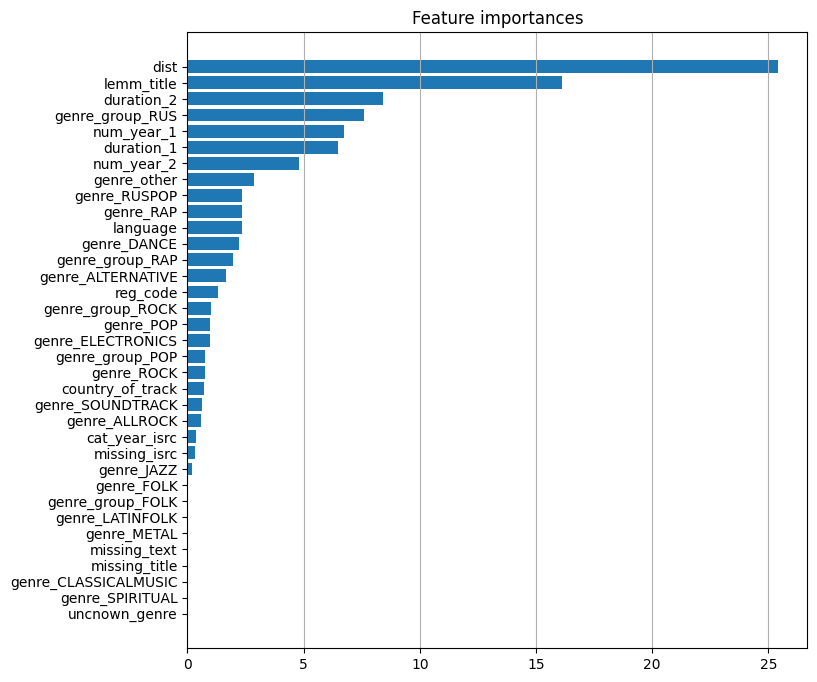

In [86]:
df_importances = df_importances.sort_values('importances')
plt.figure(figsize=(8, 8))
plt.barh(df_importances['name_feature'], df_importances['importances'])
plt.title('Feature importances')
plt.grid(axis = 'x')
plt.show()

Сильнее всего на выбор модели влияет векторное расстояние между текстами, совпадение заголовков, длительности первого и второго трека, относится ли данный трек к жанру RUS и числовой год. При этом есть признаки, которые совсем не влияют на решение данной задачи. Вероятнее всего, это связано с тем, что в этих признаках нет информации, в частности, мы рассматриваем только треки с текстом и ряд треков автоматически отваливаются, поскольку там, как правило, нет слов (например классическая музыка), а также столбцы, отвечающие за данные параметры (отсутствующий текст, отсутствующий заголовок).

#### Выбор признаков

У нас очень много признаков, проверрим какие влияют на качество модели, а какие можно отсеять. Для этого напишем функцию, которая будет перебирать признаки, убирать их по одному и смотреть на качество модели. Если качество модели не изменилось или стало лучше, то данный признак можно удалить.

Для удобства напишем функцию, которая будет возвращать среднее значение метрики кэтбуста на кросс валидации

In [87]:
def get_score_cross_val(X: pd.DataFrame, 
                        y: pd.Series,
                        cat_features: List,
                        random_state: int = 54321) -> float:
    skf = StratifiedKFold(n_splits=4)
    folds = skf.split(X, y)

    classes = np.unique(y)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    class_weights = dict(zip(classes, weights))

    cat_model = CatBoostClassifier(random_state=random_state, 
                                   cat_features=cat_features,
                                   verbose=False,
                                   class_weights=class_weights)

    cvs = cross_val_score(cat_model, X, y, cv=folds, scoring='f1')
    return mean(cvs)

In [88]:
def get_best_features(X: pd.DataFrame, 
                      y: pd.Series,
                      cat_features: List,
                      random_state: int = 54321) -> List['str']:
    drop_list = []
    is_cat_features = False
    cat_features = copy.deepcopy(cat_features)
    top_score = get_score_cross_val(X, y, cat_features, random_state) #получаем скор на всём датасете
    
    # поочерёдно удаляем столбцы
    for col in tqdm(X.columns):
        drop_list.append(col)
        if col in cat_features:
            cat_features.remove(col)
            is_cat_features = True
        X_new = X.copy(deep=True)
        X_new = X_new.drop(drop_list, axis=1)
        new_score = get_score_cross_val(X_new, y, cat_features, random_state)
        if top_score > new_score:
            drop_list.remove(col) # если скор упал, то удаляем столбец из дропа
            if is_cat_features:
                cat_features.append(col)
                is_cat_features = False
        else:
            top_score = new_score # если скор стал лучше, то заменяем его
            
    return drop_list

In [89]:
drop_columns = get_best_features(X_train, y_train, cat_features, RANDOM_STATE)

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [17:44<00:00, 30.42s/it]


Выведем получившийся список

In [90]:
drop_columns

['language',
 'missing_text',
 'missing_title',
 'genre_RAP',
 'genre_CLASSICALMUSIC',
 'genre_SPIRITUAL',
 'uncnown_genre']

Помимо оговоренных ранее жанров сюда так же попал и язык. Вероятнее всего это связано с тем, что у нас был код страны, вытянутый из isrc. Данные признаки должны сильно коррелировать и удаление одного из них могло пойти на пользу модели. Удалим данные столбцы и повторно проверим качество модели

In [91]:
X_train = X_train.drop(drop_columns, axis=1)
for col in drop_columns:
    if col in cat_features:
        cat_features.remove(col)

In [92]:
get_score_cross_val(X_train, y_train, cat_features, RANDOM_STATE)

0.8962712295210551

Качество модели немного улучшилось. Сохраним полученный список для удаления.

In [93]:
with open(PATH_TO_SAVE_COLUMNS_TO_DROP, "wb") as file:
    pickle.dump(drop_columns, file)

### Подбор гиперпараметров модели

Подберём гиперпараметры модели на GridSerchCV.

In [94]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=cat_features,
                               verbose=False,
                               class_weights=class_weights)

In [95]:
skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

In [96]:
cat_params = {'max_depth': [1, 5, 10],
             'n_estimators': range(200, 1400, 200),
             'learning_rate': [0.01, 0.03, 0.1, 0.5]}

In [97]:
%%time
grid_search = GridSearchCV(cat_model,
                           cat_params,
                           cv=folds,
                           n_jobs=-1,
                           scoring='f1',
                           verbose=False)

grid_search.fit(X_train, y_train)

CPU times: total: 2min 41s
Wall time: 17min 4s


GridSearchCV(cv=<generator object _BaseKFold.split at 0x00000214E54A2E30>,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000214E3588D00>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.1, 0.5],
                         'max_depth': [1, 5, 10],
                         'n_estimators': range(200, 1400, 200)},
             scoring='f1', verbose=False)

Посмотрим получившиеся параметры и метрику

In [98]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1200}

In [99]:
grid_search.best_score_

0.9021880764410535

Проеведём поиск на более мелкой сетке

In [100]:
cat_params = {'max_depth': [8, 10, 12],
             'n_estimators': range(1100, 1500, 100),
             'learning_rate': [0.01]}
skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

In [101]:
%%time
grid_search = GridSearchCV(cat_model,
                           cat_params,
                           cv=folds,
                           n_jobs=-1,
                           scoring='f1',
                           verbose=False)

grid_search.fit(X_train, y_train)

CPU times: total: 7min 26s
Wall time: 19min 22s


GridSearchCV(cv=<generator object _BaseKFold.split at 0x00000214E62440B0>,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000214E3588D00>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [8, 10, 12],
                         'n_estimators': range(1100, 1500, 100)},
             scoring='f1', verbose=False)

Посмотрим получившиеся параметры и метрику

In [102]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 1400}

In [103]:
grid_search.best_score_

0.9035738552945831

Тетрадь моделинг таск 2: Метрика стала ещё лучше. Повторно обучим модель, чтобы можно было проверить её на тестовой выборке.

In [104]:
%%time
cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=cat_features,
                               verbose=False,
                               class_weights=class_weights,
                               max_depth=12,
                               n_estimators=1400,
                               learning_rate=0.01)

cat_model.fit(X_train, y_train)

CPU times: total: 7min 44s
Wall time: 2min 8s


Сохраним обученную модель

In [105]:
pickle.dump(cat_model, open(PATH_TO_SAVE_MODEL, "wb"))

### Проверка на тестовой выборке

Проверим качество модели на тех данных, которые она никогда не видела.

In [106]:
df_cat_test, df_track_test = get_df(df_test, 
                                    y_test_pred, 
                                    dist_test_pred, 
                                    get_row_to_df_v2, 
                                    cat_features, 
                                    num_features,
                                    df_for_question=df_train)

100%|████████████████████████████████████████████████████████████████████████████████| 455/455 [01:33<00:00,  4.88it/s]


In [107]:
X_test = df_cat_test.drop('target', axis=1)
y_test = df_cat_test['target']

In [108]:
f1_score(y_test, cat_model.predict(X_test))

0.9311163895486936

Метрика оказалась сопоставимой, соответственно можно сделать вывод, что модель нашла требуемые патерны и позволяет получить весьма неплохой рещультат.

### Выводы

Данный раздел был направлен на разработку модели, которая принимает решение является ли какой-то из 8 треков, предложенных 1 моделью (fiass) кавером для запрашиваемого. В ходе работы было сделано следующее:

1. Исследованы 5 вариантов создания датасета и обучены по ним модели:
    - Добавления столбцов для обучения для каждого образца и добавления растояния между образцами;
    - Проверка на равнество для категориальных признаков, а для  количественных как в первом варианте;
    - Отношение для количественных признаков, а остальное как в первом варианте;
    - Объединение 2 и 3 варианта;
    - Объединение первых 3 вариантов (т.е. будем оставлять как первоначальные столбцы, так и сгенерированные).     
    
Лучшее качество показала вторая модель со значением метрики на кроссвалидации равным 0.8885

2. Исследована важность признаков для лучшей модели, сильнее всего на выбор модели влияет расстояние между векторными представлениями текстов, совпадение заголовков, длительности первого и второго трека, относится ли данный трек к жанру RUS, год записи трека из isrc в числовом формате.

3. Проведён выбор признаков при помощи поэлементного их удаления из модели и оценки качества. В результате было установлено, что столбцы 'language', 'missing_text', 'missing_title', 'genre_RAP', 'genre_CLASSICALMUSIC', 'genre_SPIRITUAL', 'unknown_genre' можно удалить, при этом качество модели улучшилось до 0.8962.

4. Осуществлён подбор гиперпараметров при помощи GridSearchCV. Оптимальными параметрами для нашей модели оказались learning_rate = 0.01, max_depth = 12, n_estimators = 1400. Это позволило увеличить качество модели до 0.9036.

5. Обученная модель была проверена на отложенной (тестовой выборке) и показала значение метрики f1 равное 0,9311, что сопоставимо с метрикой на трейне.

## Создание функции для получения группировки треков

В данном разделе напишем функцию, которая будет получать на вход предобработанные данные, обученный индекс faiss, модель CatBoost, обученный TfIdf, списки столбцов для обучения и возвращать данные по группировке трека

In [109]:
def get_predict(df: pd.DataFrame,
                df_in_index: pd.DataFrame, 
                tf_idf: TfidfVectorizer,
                index: faiss.IndexIVFFlat, 
                model: CatBoostClassifier, 
                cat_features: List, 
                num_features: List,
                id_base_dict: Dict) -> pd.DataFrame:
    # создадим словарь по трекам из датасета, на котором тренировался фаисс и получим данные из индекса для запроса
    corpus = tf_idf.transform(df['lemm_text'].fillna(''))
    y_pred, dist_pred = faiss_predict(index, corpus, id_base_dict, 8)
    
    # получим датасет с признаками и парами треков для запроса
    df_cat, df_track = get_df(df, 
                              y_pred, 
                              dist_pred, 
                              get_row_to_df_v2, 
                              cat_features, 
                              num_features,
                              is_train=False,
                              df_for_question=df_in_index)
    
    # сделаем прогноз и сформируем датасет прогноза
    df_cat[cat_features] = df_cat[cat_features].fillna('unknown')
    prediction = cat_model.predict(df_cat)
    df_track['pred'] = prediction
    
    # оставим только пары по которым модель прогнозирует совпадение
    df_track = df_track.loc[df_track['pred']==1]
    df_track = df_track.groupby('track_id_1').agg({'track_id_2': ' '.join}).reset_index()
    df_track = df_track.rename(columns={'track_id_1': 'track_id',
                                        'track_id_2': 'prediction_track_list'})    
    # присоединим прогноз к первоначальному запросу (только к столбцу track_id) и вернём ответ
    return df[['track_id']].merge(df_track, on='track_id', how='left')

Проверим функцию на валидационной выборке

In [111]:
df_predict = get_predict(df_valid, df_train, tf_idf, f_index, cat_model, cat_features, num_features, id_base_dict)

100%|████████████████████████████████████████████████████████████████████████████████| 455/455 [01:29<00:00,  5.10it/s]


Выведем результат прогноза, но смотреть будем не весь датасет, а только не пустые строки.

In [112]:
df_predict[~df_predict['prediction_track_list'].isna()].head()

,track_id,prediction_track_list
17,d2b03b45d57baa6e0c737ed3cc1836a3,d146f365b659251f0bd7a01b94c4470b
22,58f3399770dcb3fcd3619cb8937ea044,77c0ad1704a64f7a90dba4170cf8534e
33,3a72bfa66d205884fe2bc703fbe8ffa6,cf4c5a03bdc1c9c6f956b0e313ac8ce5 0826814aa50f7...
40,7cfb417a38db19631d8ee6f5e3f9243e,57e03c37397337e2a973145738c34b75 0fcb82fec458a...
44,57f8f5c2387a5e952a1a71f936b46c42,34b719ec937b6c38ede82267720d1da0 292724f1405ca...


Выберем из df_valid только столбец с track_id и cover_list, присоединим к датасету с прогнозом и сравним их (оставив только не нулевые значения)

In [113]:
pd.set_option('display.max_colwidth', None)

In [114]:
df_question = df_valid[['track_id', 'cover_list']]
df_question = df_question.merge(df_predict, on='track_id')
df_question[(~df_question['cover_list'].isna()) |
           (~df_question['prediction_track_list'].isna())].tail()

,track_id,cover_list,prediction_track_list
421,eee291784bade71a821bebe58319b63b,78da5e52e5a0c0a61500c3f6f36a1e4b,NaN
424,f614b4db25269da318b9a27fc3bb3e1d,NaN,23cb0df2d473ffa1309815fdde02a9ce
431,cf5fed3455a5eac210ef943b5cde5625,NaN,ab97358e3927d42f57c2373d2f6f12c8
435,ed541e2712a89d14b36170d912ef4698,1683e3b0e2f485882eb601801db4bc78 18ad5f6948ce88882bf3791c22a3a53f bd4162a4c4ac48be9516e116f272e355 755f08335f8436fafd3806fe9c5b867a e97ef4bf886cd850d083aec1cc54da22 7ea57e0f73df16cc71a6ab0342cd0236 c7c21c473ebdb4c8dd1fa4771b061b3a abf209547f77844456526934076358f2 f3e16bffc2216c5bd80160c5f3973835 9e20fd52b21566494b8d6586a39033c9 28efa5567f2b3c090f311a3cb8805082 073f9e9d92666ff30bdf6e7ea97208e9 f73c52d1de99fc426886378990f90a4f fd37983a6117fa525d9a35d17120652c 1dca7297005a6f9700e9eb43dd47a5e3 eb54545234f620e5f94601e5f353571d d71bd79936e69ffeb21ef6dd62e55b2e 6c56a114f6f1608c666cd67cd86042de 9a11ba5d8a9f9725ed67d78bbd4963aa 82aa19859b0f781fceca8b59de6b78ff 214c5086fd618bc642260433c867f9c7 04f227ff6ad073b4ac805d753d604337,bd4162a4c4ac48be9516e116f272e355 abf209547f77844456526934076358f2 1dca7297005a6f9700e9eb43dd47a5e3 28efa5567f2b3c090f311a3cb8805082 1683e3b0e2f485882eb601801db4bc78 214c5086fd618bc642260433c867f9c7 82aa19859b0f781fceca8b59de6b78ff 9e20fd52b21566494b8d6586a39033c9
444,8295168b2df271a91f9e4f5d6a7aad69,a7cf4d618804216039b91ecc8c50c024 8f36faa55a52681c41a6cfa1ff1176f0 acd8aad1fd68435ecd1c003bc702e53c ce39354dbe4fbfb2c8cf605fb177be5e 8aa6beb5311d751c187e88bbc0be6e66 f66a59e4931cde981b70a3ae144fb7fb 08a52b88aa5ffca6b41b58c6d5ec7a52 deb9b9598176a0bab1212d430b10bd04 f8fb3c76c159efb0033c3b48e0c2a045 97f3c02d03bcb3779c148bd060cc3483 9fa8e4a5d58ba60db3841ce48801ed58 5abc80144883057a76ea578fba6b0eef 6a0060c234c43fcffd4b3ee28621af5a f091d387e73c457838abcbb8eb044a0e,deb9b9598176a0bab1212d430b10bd04 bf8b2ce531f3844f31a147ccca54151b 8f36faa55a52681c41a6cfa1ff1176f0 f8fb3c76c159efb0033c3b48e0c2a045 97f3c02d03bcb3779c148bd060cc3483 f66a59e4931cde981b70a3ae144fb7fb


В целом модель отрабатывает нормально, но необходимо учесть, что у нас из индекса возвращается только 8 ближайших соседей, в результате модель может не увидеть очень большие цепочки (там где больше чем 8 каверов), но иначе у нас бы просело качество модели. 

In [115]:
pd.set_option('display.max_colwidth', 40)

### Финальное обучение моделей на всех доступных (размеченных) данных

Обучим модель на полной выборке доступных размеченных текстов. Для этого откроем полный датасет.

In [116]:
df_all_train = pd.read_csv(PATH_ALL_FAISS)

Натренируем TfIdf (Сохранять сейчас не будем, так как в дальнейшем планируем обучить его на всех доступных текстовых данных, а не только на размеченных) 

In [117]:
tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 3), max_features = 10000)
corpus_all = tf_idf.fit_transform(df_all_train['lemm_text'].fillna(''))

Обучим faiss и также пока не будем его сохранять

In [118]:
id_base_dict = dict(df_all_train['track_id'])
f_index = faiss_fit(corpus_all, random_state=RANDOM_STATE)
y_all_pred, dist_all_pred= faiss_predict(f_index, corpus_all, id_base_dict, 8)

Получим признаки и таргет для обучения модели

In [119]:
df_cat_all, df_track_all = get_df(df_all_train, y_all_pred, dist_all_pred, get_row_to_df_v2, cat_features, num_features)

X_all = df_cat_all.drop('target', axis=1)
y_all = df_cat_all['target']

100%|██████████████████████████████████████████████████████████████████████████████| 3032/3032 [09:28<00:00,  5.33it/s]


Проверим качество на кроссвалидации

In [120]:
get_score_cross_val(X_all, y_all, cat_features, RANDOM_STATE)

0.8594964441682208

Качество на кросс валидации всего датасета немного ниже, чем на тренировочной выборке.

Обучим финальную модель кэтбуста.

In [121]:
classes = np.unique(y_all)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_all)
class_weights = dict(zip(classes, weights))

cat_model = CatBoostClassifier(random_state=RANDOM_STATE, 
                               cat_features=cat_features,
                               verbose=False,
                               class_weights=class_weights,
                               max_depth=12,
                               n_estimators=1400,
                               learning_rate=0.01)

cat_model.fit(X_all, y_all)

Сохраним получившуюся модель

In [122]:
pickle.dump(cat_model, open(PATH_TO_SAVE_MODEL, "wb"))

Теперь нам требуется обучить TfIdf и faiss, но уже на всех текстовых данных для которых есть текст.

Откроем полный датасет, выберем строки в которых присутсвует текст и обучим TfIdf

In [123]:
df_united = pd.read_csv(PATH_UNITED_DF)
df_in_index = df_united[df_united['missing_text'] == 0].reset_index(drop=True)

In [124]:
tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 3), max_features = 10000)
corpus_united = tf_idf.fit_transform(df_in_index['lemm_text'].fillna(''))

Схраним обученный векторизатор

In [125]:
pickle.dump(tf_idf, open(PATH_TFIDFVECTORIZER, "wb"))

Обучим индекс faiss и словарь с id.

In [126]:
id_base_dict = dict(df_in_index['track_id'])
f_index = faiss_fit(corpus_united, random_state=RANDOM_STATE)

Сохраним их.

In [127]:
write_index(f_index, PATH_TO_SAVE_FAISS)

In [128]:
with open(PATH_TO_SAVE_ID_BASE_DICT, "wb") as file:
    pickle.dump(id_base_dict, file)

### Создание функции для обработки запроса на нахождения кавера

Тетрадка моделинг таск 2: Поскольку на вход будет подаваться запрос из датасета, в котором могут быть песни со словами или без них, то необходимо предусмотреть обработку таких ситуаций. Предлагаем следующую логику решения данной задачи:

1. Проверяем есть ли в датасете треки без текста. Если есть, то ставим им отметку, что для данного трека нахождение кавера невозможно (сделаем булевый флаг ставить такую отметку или оставлять такие строки пустыми).
2. По трекам у которых есть текст отправляем запрос по написанной ранее функции и указываем треки, если они есть. Если их нет, то будут стоять значения NaN.

In [129]:
def get_list_cover(df: pd.DataFrame,
                   df_in_index: pd.DataFrame,
                   tf_idf: TfidfVectorizer,
                   index: faiss.IndexIVFFlat, 
                   model: CatBoostClassifier, 
                   cat_features: List, 
                   num_features: List,
                   id_base_dict: Dict,
                   fill_not_text_row: bool=False) -> pd.DataFrame:
    df = df.copy(deep=True)
    df['prediction_track_list'] = np.nan
    if fill_not_text_row:
        df.loc[df['missing_text'] == 1, 'prediction_track_list'] = 'Нет информации о тексте данного трека, определение кавера невозможно'
       
    df_question = df.loc[df['missing_text'] == 0].reset_index(drop=True)
    df.loc[df['missing_text'] == 0, 'prediction_track_list'] = get_predict(df_question, 
                                                                           df_in_index, 
                                                                           tf_idf,
                                                                           index, 
                                                                           model, 
                                                                           cat_features, 
                                                                           num_features,
                                                                           id_base_dict)['prediction_track_list']
    return df[['track_id', 'prediction_track_list']]

Повторно откроем полный датасет

In [130]:
df_united = pd.read_csv(PATH_UNITED_DF)

In [131]:
df_predict = get_list_cover(df_united, df_in_index, tf_idf, f_index, cat_model, cat_features, num_features, id_base_dict)

100%|████████████████████████████████████████████████████████████████████████████| 10205/10205 [50:20<00:00,  3.38it/s]


In [133]:
df_predict.head()

,track_id,prediction_track_list
0,c3b9d6a354ca008aa4518329aaa21380,804589c2558377b846122344fdc54a72
1,c57e3d13bbbf5322584a7e92e6f1f7ff,27d7308fb6fa94b7131dd746b80d99de c66...
2,955f2aafe8717908c140bf122ba4172d,NaN
3,fae5a077c9956045955dde02143bd8ff,NaN
4,6bede082154d34fc18d9a6744bc95bf5,NaN


Сохраним обученную модель

In [135]:
df_predict.to_csv(PATH_SAVE_PREDICTION, index=False)

### Выводы

В данном разделе была проделана следующая работа:
1. Написаны функции, обеспечивающие возвращение прогноза в виде датафрейма, состоящего из двух столбцов:
    - track_id - id трека запроса и 
    - prediction_track_list - спрогнозированный список возможных каверов (представляется в виде строки id треков, разделёнными пробелами). 
2. Обучены на всех доступных данных и сохранены: векторизатор TfidfVectorizer, индекс faiss, модель.
3. Сделан и сохранён прогноз для всех данных.

## Выводы по ноутбуку

Данный ноутбук был посвящён решению второй задачи: группировке каверов и исходного трека. В ходе решения были достигнуты следующие результаты:
1.  Выбрана стратегия решения данной задачи при которой мы ищем результат в два этапа:
      * находим k ближайших треков по векторизованному тексту песни при помощи faiss (на данном этапе будут оптимизироваться параметры векторизатора и самого faiss)
          * в качестве основной метрики выбран Recall@k;
      * при помощи ML модели определяем какие из предложенных треков можно сгруппировать. Для этого для каждого трека запроса будет формироваться датасет, в который войдут все сочетания пар исходный трек - трек из k ближайших. После чего на данном датасете будет обучена и оптимизирована модель
          * в качестве метрики выбрана f1 мера.
2.  Согласно выбранной стратегии был обучен индекс faiss и оптимизированы параметры как faiss, так и TfIdf результатом данного этапа стало:
      * подобраны оптимальные параметры для TfIdf текстов песен (n_gram = (1, 3), max_features = 10000);
      * на основании f1 было установлено, что оптимально возвращать 8 ближайших соседей;
      * при исследовании результатов модели, было обнаружено, что в датасете отобранном для тренировочных данных 32 пар треков с 0 расстоянием и разным original_track_id (примерно 1.5%), вероятнее всего это является ошибкой разметки данных.
3.  Для второй ступени выбранной модели необходимо было обучить модель, которая принимала бы решение какие из предложенных 8 ближайших треков, могут выступать в качестве пар. Этот этап получился достаточно объёмным, поэтому разобьём его на подэтапы:
      * подбор стратегии формирования датасета для обучения. Было рассмотрено несколько вариантов формирования датасета для обучения модели, для каждого из них была обучена модель и выбрана лучшая на основании f1 меры. Лучшие варианты показал датасет, в котором категориальные образцы для каждой из пар треков проверялись на равенство, а количественные признаки брались как для первого, так и для второго трека;
      * проведён анализ важности признаков: сильнее всего на выбор модели влияет расстояние между векторными представлениями текстов, совпадение заголовков, длительности первого и второго трека, относится ли данный трек к жанру RUS и год записи трека из isrc в числовом формате;
      * проведён выбор признаков поэлементным удалением столбцов и найдены столбцы, удаление которых позволяет улучшить качество модели (или не влияет на него);
      * были подобраны гиперпараметры, что в итоге позволило получить на кроссвалидации качество равное 0.9036 и на отложенной выборке равное 0,9311
4.  Созданы функции, которые позволяют делать полноценный прогноз по запросу в виде предобработанного датасета и возвращать датасет с конкретным track_id и списком track_id вероятных каверов (или оригинала)
5.  Обучены на всех доступных данных все требуемые модели. На доступном датасете сделан прогноз.

## Возможное улучшение модели.

Ниже приведены предложения по улучшению модели для её улучшения:
- Как было установлено в первом разделе: в данных, некоторые треки имеют неправильную разметку (имеют разный оригинал при полном совпадении треков), можно найти такие треки плюс треки, в которых модель сильно уверена, что они являются каверами, а в разметке они не каверы. После проверить их вручную, и, при необходимости, поправить разметку. После этого повторно обучить модель. Возможно, это позволит ей обнаружить новые закономерности.
- Попробовать векторизовать заголовки и найти растояние между ними, возможно, это позволит модели найти схожие заголовки, которые формально не равны.